In [1]:
#pip install datasets

# Summarization

we will build our own encoder-decoder model to condense dialogues
between several people into a crisp summary. But before we get to that, let’s begin by
taking a look at one of the the canonical datasets for summarization: the CNN/DailyMail
corpus.

The CNN/DailyMail dataset consists of around 300,000 pairs of news articles and
their corresponding summaries, composed from the bullet points that CNN and the
DailyMail attach to their articles.

An important aspect of the dataset is that the summaries are abstractive and not extractive, which means that they consist of new
sentences instead of simple excerpts.

we’ll use
version 3.0.0, which is a nonanonymized version set up for summarization. We can
select versions in a similar manner as splits,



In [1]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", '3.0.0')  # Specify the desired version
print(f"Features: {dataset['train'].column_names}")

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Features: ['article', 'highlights', 'id']


In [2]:
# Let’s look at an excerpt from an article:
sample = dataset["train"][1]
print(f"""
Article (excerpt of 500 characters, total length: {len(sample["article"])}):
""")
print(sample["article"][:500])
print(f'\nSummary (length: {len(sample["highlights"])}):')
print(sample["highlights"])


Article (excerpt of 500 characters, total length: 4051):

Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most s

Summary (length: 281):
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .


We see that the articles can be very long compared to the target summary; in this par‐
ticular case the difference is 17-fold. Long articles pose a challenge to most trans‐
former models since the context size is usually limited to 1,000 tokens or so, which is
equivalent to a few paragraphs of text. The standard, yet crude way to deal with this
for summarization is to simply truncate the texts beyond the model’s context size.
Obviously there could be important information for the summary toward the end of
the text, but for now we need to live with this limitation of the model architectures.

# Text Summarization Pipelines

Let’s see how a few of the most popular transformer models for summarization per‐
form by first looking qualitatively at the outputs for the preceding example.

let’s
restrict the input text to 2,000 characters to have the same input for all models and
thus make the outputs more comparable:

In [4]:
sample_text = dataset["train"][1]["article"][:2000]
# We'll collect the generated summaries of each model in a dictionary
summaries = {}

The Natural Language Toolkit (NLTK) package
includes a more sophisticated algorithm that can differentiate the end of a sentence
from punctuation that occurs in abbreviations:

In [5]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

string = "The U.S. are a country. The U.N. is an organization."
sent_tokenize(string)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['The U.S. are a country.', 'The U.N. is an organization.']


In the following sections we will load several large models. If you
run out of memory, you can either replace the large models with
smaller checkpoints (e.g., “gpt”, “t5-small”)

# Summarization Baseline


A common baseline for summarizing news articles is to simply take the first three
sentences of the article.

In [6]:
def three_sentence_summary(text):
  return "\n".join(sent_tokenize(text)[:3])


summaries["baseline"] = three_sentence_summary(sample_text)

In [7]:
summaries

{'baseline': 'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.\nHere, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.\nMIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."'}

# GPT-2

We will start our summarization experiment by re-creating the
procedure of the original paper with the pipeline() function from Transformers.1

In [8]:
from transformers import pipeline, set_seed
set_seed(42)
pipe = pipeline("text-generation", model="gpt2-xl")
gpt2_query = sample_text + "\nTL;DR:\n"
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
summaries["gpt2"] = "\n".join(
sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query) :]))

2024-07-14 13:03:14.658835: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-14 13:03:14.658966: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-14 13:03:14.821783: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


# T5

The T5 checkpoints are trained on a mixture of unsupervised data (to

reconstruct masked words) and supervised data for several tasks, including summari‐
zation. These checkpoints can thus be directly used to perform summarization
without fine-tuning by using the same prompts used during pretraining.

In this
framework, the input format for the model to summarize a document is "summarize:
<ARTICLE>", and for translation it looks like "translate English to German:
<TEXT>".

We can directly load T5 for summarization with the pipeline() function, which also
takes care of formatting the inputs in the text-to-text format so we don’t need to pre‐
pend them with "summarize":



In [9]:
pipe = pipeline("summarization", model="t5-large")
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


# BART

BART also uses an encoder-decoder architecture and is trained to reconstruct cor‐
rupted inputs. It combines the pretraining schemes of BERT and GPT-2.2
We’ll use
the facebook/bart-large-ccn checkpoint, which has been specifically fine-tuned on
the CNN/DailyMail dataset:

In [10]:
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


# PEGASUS

Like BART, PEGASUS is an encoder-decoder transformer.3

its pretraining objective is to predict masked sentences in multisentence texts. The
authors argue that the closer the pretraining objective is to the downstream task, the
more effective it is.


This model has a special token for newlines, which is why we don’t need the
sent_tokenize() function:

In [11]:
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


# Comparing Different Summaries

Now that we have generated summaries with four different models, let’s compare the
results. Keep in mind that one model has not been trained on the dataset at all
(GPT-2), one model has been fine-tuned on this task among others (T5), and two
models have exclusively been fine-tuned on this task (BART and PEGASUS).

In [12]:
print("GROUND TRUTH")
print(dataset["train"][1]["highlights"])
print("")


for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")

GROUND TRUTH
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .

BASELINE
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.
Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."

GPT2
To get to the jail, you go up a flight of stairs, pass a metal detector, and go down a hall.
The inmates are so scared that they'll be thrown in jail for not turning up your appointment.
The first room to the right is 

The first thing we notice by looking at the model outputs is that the summary gener‐
ated by GPT-2 is quite different from the others. Instead of giving a summary of the
text, it summarizes the characters. Often the GPT-2 model “hallucinates” or invents
facts, since it was not explicitly trained to generate truthful summaries.

Now that we have inspected a few models, let’s try to decide which one we would use
in a production setting. All four models seem to provide qualitatively reasonable
results, and we could generate a few more examples to help us decide. However, this
is not a systematic way of determining the best model!

In the next section we will look at some common metrics that have been developed
for measuring the quality of generated text.

# Measuring the Quality of Generated Text

Two of the most common metrics used to evaluate generated text are BLEU and
ROUGE. Let’s take a look at how they’re defined.

# BLEU

The idea of BLEU is simple:4

instead of looking at how many of the tokens in the gen‐
erated texts are perfectly aligned with the reference text tokens, we look at words or
n-grams. BLEU is a precision-based metric, which means that when we compare the
two texts we count the number of words in the generation that occur in the reference
and divide it by the length of the generation.


However, there is an issue with this vanilla precision. Assume the generated text just
repeats the same word over and over again, and this word also appears in the refer‐
ence. If it is repeated as many times as the length of the reference text, then we get perfect precision! For this reason, the authors of the BLEU paper introduced a slight
modification: a word is only counted as many times as it occurs in the reference.


To
illustrate this point, suppose we have the reference text “the cat is on the mat” and the
generated text “the the the the the the”.


From this simple example, we can calculate the precision values as follows:

pvanilla =
6
/6

pmod =
2
/6


Now let’s extend this by not only looking at single words, but n-grams as well.
Let’s assume we have one generated sentence, snt, that we want to compare against a
reference sentence, snt′. We extract all possible n-grams of degree n and do the
accounting to get the
precision pn

In order to avoid rewarding repetitive generations, the count in the numerator is clip‐
ped. What this means is that the occurrence count of an n-gram is capped at how
many times it appears in the reference sentence. Also note that the definition of a sen‐
tence is not very strict in this equation, and if you had a generated text spanning mul‐
tiple sentences you would treat it as one sentence.


We’re almost there. Since we are not looking at recall, all generated sequences that are
short but precise have a benefit compared to sentences that are longer. Therefore, the
precision score favors short generations. To compensate for that the authors of BLEU
introduced an additional term, the brevity penalty:


By taking the minimum, we ensure that this penalty never exceeds 1 and the expo‐
nential term becomes exponentially small when the length of the generated text lgen is
smaller than the reference text lre f . At this point you might ask, why don’t we just use
something like an F1

-score to account for recall as well? The answer is that often in
translation datasets there are multiple reference sentences instead of just one, so if we
also measured recall we would incentivize translations that used all the words from all
the references. Therefore, it’s preferable to look for high precision in the translation
and make sure the translation and reference have a similar length.

Finally, we can put everything together and get the equation for the BLEU score:

The last term is the geometric mean of the modified precision up to n-gram N. In
practice, the BLEU-4 score is often reported. However, you can probably already see
that this metric has many limitations; for instance, it doesn’t take synonyms into
account, and many steps in the derivation seem like ad hoc and rather fragile heuris‐
tics. You can find a wonderful exposition of BLEU’s flaws in Rachel Tatman’s blog
post


Another weakness of the BLEU metric is that it expects the text to already
be tokenized. This can lead to varying results if the exact same method for text toke‐
nization is not used. The SacreBLEU metric addresses this issue by internalizing the
tokenization step; for this reason, it is the preferred metric for benchmarking.

Loading a metric works just
like loading a dataset:

In [13]:
pip install sacrebleu

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 981.6 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.9 MB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [14]:
from datasets import load_metric
bleu_metric = load_metric("sacrebleu")

/tmp/ipykernel_34/3482725883.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("sacrebleu")


The repository for sacrebleu contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/sacrebleu.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


The bleu_metric object is an instance of the Metric class, and works like an aggrega‐
tor: you can add single instances with add() or whole batches via add_batch(). Once
you have added all the samples you need to evaluate, you then call compute() and the
metric is calculated. This

In [15]:
import pandas as pd
import numpy as np
bleu_metric.add(
prediction="the the the the the the", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


We can see the precision of the 1-gram is indeed 2/6, whereas the precisions for the
2/3/4-grams are all 0. (For more information about the individual metrics, like counts
and bp, see the SacreBLEU repository.)

This means the geometric mean is zero, and
thus also the BLEU score. Let’s look at another example where the prediction is
almost correct:

In [16]:
bleu_metric.add(
prediction="the cat is on mat", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


The BLEU score is widely used for evaluating text, especially in machine translation,
since precise translations are usually favored over translations that include all possible
and appropriate words.

There are other applications, such as summarization, where the situation is different.
There, we want all the important information in the generated text, so we favor high
recall. This is where the ROUGE score is usually used.

# ROUGE
The ROUGE score was specifically developed for applications like summarization
where high recall is more important than just precision.5 The approach is very similar
to the BLEU score in that we look at different n-grams and compare their occurrences
in the generated text and the reference texts. The difference is that with ROUGE we
check how many n-grams in the reference text also occur in the generated text.


For
BLEU we looked at how many n-grams in the generated text appear in the reference,
so we can reuse the precision formula with the minor modification that we count
the (unclipped) occurrence of reference n-grams in the generated text in the
denominator:


This was the original proposal for ROUGE. Subsequently, researchers have found that
fully removing precision can have strong negative effects. Going back to the BLEU
formula without the clipped counting, we can measure precision as well, and we can
then combine both precision and recall ROUGE scores in the harmonic mean to get
an F1
-score. This score is the metric that is nowadays commonly reported for
ROUGE.




There is a separate score in ROUGE to measure the longest common substring (LCS),
called ROUGE-L. The LCS can be calculated for any pair of strings. For example, the
LCS for “abab” and “abc” would be “ab”, and its the length would be 2. If we want to
compare this value between two samples we need to somehow normalize it because
otherwise a longer text would be at an advantage. To achieve this, the inventor of
ROUGE came up with an F-score-like scheme where the LCS is normalized with the
length of the reference and generated text, then the two normalized scores are mixed
together:

That way the LCS score is properly normalized and can be compared across samples.
In the Datasets implementation, two variations of ROUGE are calculated: one cal‐
culates the score per sentence and averages it for the summaries (ROUGE-L), and the
other calculates it directly over the whole summary (ROUGE-Lsum).

In [17]:
pip install rouge_score

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=0ba451bb13efa787756ec853d1acdca48478c517faff5e9b092be63f3effce45
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
Note: you may need to restart the kernel to use updated packages.


In [18]:
rouge_metric = load_metric("rouge")

The repository for rouge contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/rouge.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


We already generated a set of summaries with GPT-2 and the other models, and now
we have a metric to compare the summaries systematically. Let’s apply the ROUGE
score to all the summaries generated by the models:

In [19]:
reference = dataset["train"][1]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

In [20]:
for model_name in summaries:
    rouge_metric.add(prediction=summaries[model_name], reference=reference)
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
    records.append(rouge_dict)

pd.DataFrame.from_records(records, index=summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.365079,0.145161,0.206349,0.285714
gpt2,0.271186,0.051724,0.152542,0.271186
t5,0.382979,0.130435,0.255319,0.382979
bart,0.475248,0.222222,0.316832,0.415842
pegasus,0.323232,0.206186,0.282828,0.323232


These results are obviously not very reliable as we only looked at a single sample, but
we can compare the quality of the summary for that one example. The table confirms
our observation that of the models we considered, GPT-2 performs worst. This is not
surprising since it is the only model of the group that was not explicitly trained to
summarize.


these results
should be treated with caution as we only evaluated the models on a single example.
Looking at the results in the PEGASUS paper, we would expect the PEGASUS to out‐
perform T5 on the CNN/DailyMail dataset.

Let’s see if we can reproduce those results with PEGASUS.

# Evaluating PEGASUS on the CNN/DailyMail Dataset

Let’s first evaluate the
performance of the three-sentence baseline:

In [21]:
def evaluate_summaries_baseline(dataset, metric,
                                column_text="article",
                                column_summary="highlights"):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries,
    references=dataset[column_summary])
    score = metric.compute()
    return score

Now we’ll apply the function to a subset of the data. Since the test fraction of the
CNN/DailyMail dataset consists of roughly 10,000 samples, generating summaries for
all these articles takes a lot of time.

For the purpose of keeping the calculations rel‐
atively fast, we’ll subsample the test set and run the evaluation on 1,000 samples
instead. This should give us a much more stable score estimation while completing in
less than one hour on a single GPU for the PEGASUS model:

In [22]:
test_sampled = dataset["test"].shuffle(seed=42).select(range(1000))
score = evaluate_summaries_baseline(test_sampled, rouge_metric)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.389276,0.171296,0.245061,0.354239


Now let’s implement the same evaluation function for evaluating
the PEGASUS model:

In [23]:
from tqdm import tqdm
import torch


device = "cuda" if torch.cuda.is_available() else "cpu"
def chunks(list_of_elements, batch_size):
    """Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

In [24]:
def evaluate_summaries_pegasus(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="article",
                               column_summary="highlights"):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)

        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]
        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    score = metric.compute()
    return score

Let’s unpack this evaluation code a bit. First we split the dataset into smaller batches
that we can process simultaneously. Then for each batch we tokenize the input arti‐
cles and feed them to the generate() function to produce the summaries using beam
search. We use the same generation parameters as proposed in the paper. The new
parameter for length penalty ensures that the model does not generate sequences that
are too long. Finally, we decode the generated texts, replace the <n> token, and add
the decoded texts with the references to the metric. At the end, we compute and
return the ROUGE scores. Let’s now load the model again with the AutoModelFor
Seq2SeqLM class, used for seq2seq generation tasks, and evaluate it:

In [25]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
score = evaluate_summaries_pegasus(test_sampled, rouge_metric,
                                  model, tokenizer,
                                   batch_size=8)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 125/125 [26:01<00:00, 12.49s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.012382,0.00052,0.012273,0.012373


One thing to note here is that
the loss and per-token accuracy are decoupled to some degree from the ROUGE
scores. The loss is independent of the decoding strategy, whereas the ROUGE score is
strongly coupled.

Since ROUGE and BLEU correlate better with human judgment than loss or accu‐
racy, we should focus on them and carefully explore and choose the decoding strategy
when building text generation models. These metrics are far from perfect, however,
and one should always consider human judgments as well.

# Training a Summarization Model

We’ve worked through a lot of details on text summarization and evaluation, so let’s
put this to use to train a custom text summarization model! For our application, we’ll
use the SAMSum dataset developed by Samsung, which consists of a collection of dia‐
logues along with brief summaries.

In an enterprise setting, these dialogues might
represent the interactions between a customer and the support center, so generating
accurate summaries can help improve customer service and detect common patterns
among customer requests. Let’s load it and look at an example:

In [27]:
pip install py7zr

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [29]:
dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]
print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

The repository for samsum contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/samsum.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


The dialogues look like what you would expect from a chat via SMS or WhatsApp,
including emojis and placeholders for GIFs. The dialogue field contains the full text
and the summary the summarized dialogue. Could a model that was fine-tuned on the
CNN/DailyMail dataset deal with that? Let’s find out!

# Evaluating PEGASUS on SAMSum
First we’ll run the same summarization pipeline with PEGASUS to see what the out‐
put looks like. We can reuse the code we used for the CNN/DailyMail summary
generation:

In [30]:
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print("Summary:")
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))

Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Summary:
Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


We can see that the model mostly tries to summarize by extracting the key sentences
from the dialogue. This probably worked relatively well on the CNN/DailyMail data‐
set, but the summaries in SAMSum are more abstract. Let’s confirm this by running
the full ROUGE evaluation on the test set:

In [31]:

# hide_output
score = evaluate_summaries_pegasus(dataset_samsum["test"], rouge_metric, model,
                                   tokenizer, column_text="dialogue",
                                   column_summary="summary", batch_size=8)

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

100%|██████████| 103/103 [19:26<00:00, 11.32s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.015564,0.000294,0.015572,0.015588


Well, the results aren’t great, but this is not unexpected since we’ve moved quite a bit
away from the CNN/DailyMail data distribution. Nevertheless, setting up the evalua‐
tion pipeline before training has two advantages: we can directly measure the success
of training with the metric and we have a good baseline.

Fine-Tuning PEGASUS
Before we process the data for training, let’s have a quick look at the length distribu‐
tion of the input and outputs:

Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


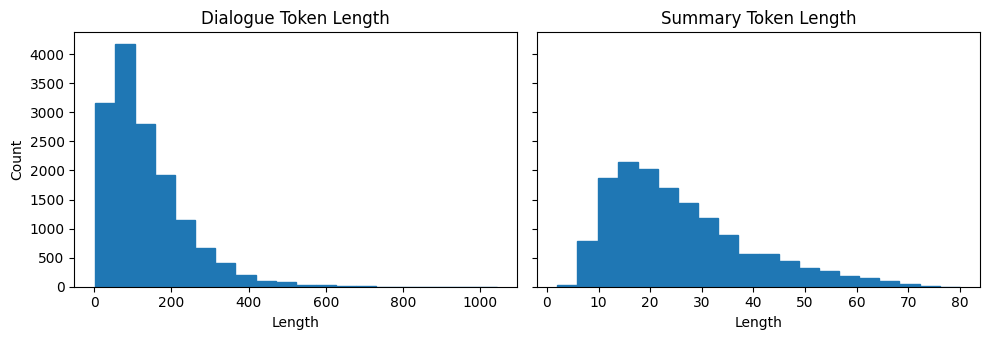

In [32]:
import matplotlib.pyplot as plt # Import the pyplot submodule

d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

We see that most dialogues are much shorter than the CNN/DailyMail articles, with
100–200 tokens per dialogue. Similarly, the summaries are much shorter, with around
20–40 tokens (the average length of a tweet).

Let’s keep those observations in mind as we build the data collator for the Trainer.
First we need to tokenize the dataset. For now, we’ll set the maximum lengths to 1024
and 128 for the dialogues and summaries, respectively:

In [33]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024,
                                truncation=True)

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128,
                                     truncation=True)

    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features,
                                       batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

A new thing in the use of the tokenization step is the tokenizer.as_target_token
izer() context. Some models require special tokens in the decoder inputs, so it’s
important to differentiate between the tokenization of encoder and decoder inputs. In
the with statement (called a context manager), the tokenizer knows that it is tokeniz‐
ing for the decoder and can process sequences accordingly.

Now, we need to create the data collator. This function is called in the Trainer just
before the batch is fed through the model. In most cases we can use the default colla‐
tor, which collects all the tensors from the batch and simply stacks them. For the
summarization task we need to not only stack the inputs but also prepare the targets
on the decoder side.

PEGASUS is an encoder-decoder transformer and thus has the
classic seq2seq architecture. In a seq2seq setup, a common approach is to apply
“teacher forcing” in the decoder. With this strategy, the decoder receives input tokens
(like in decoder-only models such as GPT-2) that consists of the labels shifted by one
in addition to the encoder output; so, when making the prediction for the next token
the decoder gets the ground truth shifted by one as an input,

In [37]:
text = ['PAD','Transformers', 'are', 'awesome', 'for', 'text', 'summarization']
rows = []
for i in range(len(text)-1):
    rows.append({'step': i+1, 'decoder_input': text[:i+1], 'label': text[i+1]})
pd.DataFrame(rows).set_index('step')

,decoder_input,label
step,,
1,[PAD],Transformers
2,"[PAD, Transformers]",are
3,"[PAD, Transformers, are]",awesome
4,"[PAD, Transformers, are, awesome]",for
5,"[PAD, Transformers, are, awesome, for]",text
6,"[PAD, Transformers, are, awesome, for, text]",summarization


We shift it by one so that the decoder only sees the previous ground truth labels and
not the current or future ones. Shifting alone suffices since the decoder has masked
self-attention that masks all inputs at present and in the future.

So, when we prepare our batch, we set up the decoder inputs by shifting the labels to
the right by one. After that, we make sure the padding tokens in the labels are ignored
by the loss function by setting them to –100. We actually don’t have to do this man‐
ually, though, since the DataCollatorForSeq2Seq comes to the rescue and takes care
of all these steps for us:

In [38]:
from transformers import DataCollatorForSeq2Seq
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [40]:
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
                                output_dir='pegasus-samsum',
                                num_train_epochs=1,
                                warmup_steps=500,
                                per_device_train_batch_size=1,
                                per_device_eval_batch_size=1,
                                weight_decay=0.01,
                                logging_steps=10,
                                push_to_hub=True,
                                eval_strategy='steps',
                                eval_steps=500, 
                                save_steps=1e6,
                                gradient_accumulation_steps=16
                                )

One thing that is different from the previous settings is that new argument,
gradient_accumulation_steps. Since the model is quite big, we had to set the batch
size to 1. However, a batch size that is too small can hurt convergence. To resolve that
issue, we can use a nifty technique called gradient accumulation. As the name sug‐
gests, instead of calculating the gradients of the full batch all at once, we make smaller
batches and aggregate the gradients.

Let’s now make sure that we are logged in to Hugging Face so we can push the model
to the Hub after training:

In [41]:
from huggingface_hub import notebook_login
notebook_login()

In [42]:
trainer = Trainer(model=model,
                  args=training_args,
                  tokenizer=tokenizer,
                  data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"]
                  )

In [43]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/transformers/data/data_collator.py:656: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:261.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'min_length': 32, 'num_beams': 8, 'length_penalty': 0.8, 'forced_eos_token_id': 1}


TrainOutput(global_step=460, training_loss=2.004107477353967, metrics={'train_runtime': 4879.9071, 'train_samples_per_second': 3.019, 'train_steps_per_second': 0.094, 'total_flos': 7673700761518080.0, 'train_loss': 2.004107477353967, 'epoch': 0.9991854466467553})

In [44]:
score = evaluate_summaries_pegasus(
    dataset_samsum["test"], rouge_metric, trainer.model, tokenizer,
    batch_size=2, column_text="dialogue", column_summary="summary")

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f"pegasus"])

100%|██████████| 410/410 [13:13<00:00,  1.93s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.018579,0.000296,0.018447,0.018482


In [46]:
# Let’s push our model to the Hub:
trainer.push_to_hub("Training complete!")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'min_length': 32, 'num_beams': 8, 'length_penalty': 0.8, 'forced_eos_token_id': 1}


CommitInfo(commit_url='https://huggingface.co/sagar213/pegasus-samsum/commit/8b0d0ef98cf9826162a0614828299ea68e3b25b3', commit_message='Training complete!', commit_description='', oid='8b0d0ef98cf9826162a0614828299ea68e3b25b3', pr_url=None, pr_revision=None, pr_num=None)

# Generating Dialogue Summaries

Looking at the losses and ROUGE scores, it seems the model is showing a significant
improvement over the original model trained on CNN/DailyMail only. Let’s see what
a summary generated on a sample from the test set looks like:

In [47]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
pipe = pipeline("summarization", model="transformersbook/pegasus-samsum")
print("Dialogue:")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

Model Summary:
Amanda can't find Betty's number. Larry called Betty last time they were at the park together. Hannah wants Amanda to text Larry instead of calling Betty.


Now, the
ultimate test: how well does the model work on a custom input?

In [48]:
custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!
"""
print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 128, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Thom, Lewis and Leandro are going to write a book about transformers. Thom helped build a library by Hugging Face. They are going to do it together.
